# PRICING AND HEDGING - Lista 2

Exercício 2:

Transformem o P&L final do portfolio em uma função e calculem a breakeven vol das 500 trilhas anteriores
para o strike K=S0. Qual a distribuição? Gerem um scatter plot das breakeven vols vs as vols realizadas das
trilhas.

## Break Even Volatility (BEV)

If we sell an option for a premium corresponding to some volatility and perform delta hedge computed with the same volatility.
We end up with a profit and loss that depends on $\sigma$: P&L($\sigma$).
The $\sigma$ that sets this P&L to zero is called the Break Even Volatility.

## Using methods from DermanPapers

In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

%matplotlib inline

def ca(x, size):
    y = np.empty(size)
    y.fill(x)
    return y

def ppzero(s):
    return pd.Series(pd.Series.append(pd.Series([0]), s).values)

def mcpath(nsteps, S0, drift, vol, t):
    # Generates nsteps random numbers N(0, 1)
    nmdr = pd.Series(np.random.standard_normal(nsteps))
    # Time discretization
    dt = t/nsteps
    # Create an array of dt
    ts = pd.Series(ca(dt, nsteps))
    # Include initial t0
    ts0 = ppzero(ts)
    s1 = (drift - pow(vol, 2)/2) * dt
    s2 = vol * np.sqrt(dt)
    # Steps = Sum of two vectors
    steps = s1 * pd.Series(ca(1, nsteps)) + s2 * nmdr
    steps0 = ppzero(steps)
    # Accumulate
    cmsteps = steps0.cumsum()
    cmts = ts0.cumsum()
    # Convert steps to path
    Sj = S0 * np.exp( cmsteps.values )
    # create timeseries [t,St]
    path=pd.Series(Sj, index=cmts.values)
    
    return path

def mcpaths(npaths, nsteps, S0, drift, vol, t):
    # generate npaths using mcpath
    paths=[mcpath(nsteps, S0, drift, vol, t) for j in range(npaths)]
    return paths

def bsv(phi, S, K, r, q, vol, t):
    if (t > 0):
        fwd=S*np.exp((r-q)*t)
        efv=t*(vol**2)
        # calculate d1 and d2
        d1=(np.log(fwd/K)+(efv/2))/(np.sqrt(efv))
        d2=(np.log(fwd/K)-(efv/2))/(np.sqrt(efv))
        # calculate N(d1) and N(d2)
        Nd1=st.norm.cdf(phi*d1)
        Nd2=st.norm.cdf(phi*d2)
        # calculate premium
        pr=phi*S*np.exp(-q*t)*Nd1-phi*K*np.exp(-r*t)*Nd2
        # calculate delta
        de=phi*np.exp(-q*t)*Nd1
    else:
        de = 0
        if (phi == 1):
            pr = max(S-K, 0)
        else:
            pr = max(K-S, 0)
        
    return [pr, de]

def calcpath(path, phi, K ,r, q, vol, T):
    ttm=T-path.index
    bsvpath=np.array([[path.index[j], path.values[j]] + bsv(phi, path.values[j], K, r, q, vol, ttm[j])\
                      for j in range(len(path))])

    return pd.DataFrame(bsvpath,columns=['time','spot','premium','delta'])

def filldf(path, phi, K, r, q, vol, T):
    nstp=len(path)-1
    # calculate t,S(t),premium(t),delta(t)
    df=calcpath(path, phi, K, r, q, vol, T)
    # cashflows for the option
    df['cfwprem']=0
    df.loc[0,'cfwprem']=-df['premium'][0]
    df.loc[nstp,'cfwprem']=df['premium'][nstp]
    df.loc[nstp,'premium']=0
    # calculate time intervals dt
    df['timechg']=df['time'].diff()
    df.loc[0,'timechg']=0
    # calculate changes in delta
    df.loc[nstp,'delta']=0
    df['dltchg']=df['delta'].diff()
    df.loc[0,'dltchg']=0
    # calculate changes in spot price
    df['spotchg']=df['spot'].diff()
    df.loc[0,'spotchg']=0
    # cashflows for the asset
    df['cfwspot']=0
    df.loc[0,'cfwspot']=df['delta'][0]*df['spot'][0]
    df.loc[1:,'cfwspot']=df['dltchg'][1:]*df['spot'][1:]
    # dividend cashflows
    df['cfwdivid']=0
    df.loc[1:,'cfwdivid']=-((df['delta'][0:nstp]*df['spot'][0:nstp]).values)*(np.exp(q*df['timechg'][1:].values)-1)
    # cashflows before interest
    df['cfwprer']=df['cfwprem']+df['cfwspot']+df['cfwdivid']
    # interest and consolidation of cashflows
    df['balance']=0
    df.loc[0,'balance']=df['cfwprer'][0]
    for j in range(1,nstp+1):
        df.loc[j,'balance']=df['balance'][j-1]*(np.exp(r*df['timechg'][j]))+df['cfwprer'][j]
    # portfolio
    df['portf']=df['premium']-df['delta']*df['spot']+df['balance']
    # consolidated discount factor
    return df

def portfolio(path, phi, K, r, q, vol, T):
    fulldf=filldf(path, phi, K, r, q, vol, T)
    return pd.Series(fulldf['portf'].values)

Modifying method finalpl:

In [2]:
def finalpl(vol, path, phi, K, r, q, T):
    portf=portfolio(path, phi, K, r, q, vol, T)
    return portf[len(path)-1]

## Running the exercise

In [3]:
call = 1
put = -1
S0 = 100
K = 100
actualVol = 0.30
impliedVol = 0.20
T = 1
q = 0
r = 0
numPaths = 500
numSteps = 500
phi = call

Simulate stock paths:

In [4]:
paths = mcpaths(numPaths, numSteps, S0, r-q, actualVol, T)

Find Break Even Volatilities using Newthon method:

In [5]:
import scipy.optimize as opt

bevs = pd.Series(np.array([opt.newton(finalpl, impliedVol, args=(path, phi, K, r, q, T)) for path in paths]))

## Break Even Volatilities distribuition

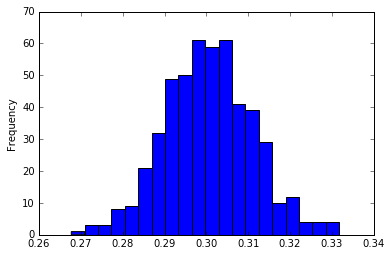

In [6]:
bevs.plot(kind='hist', bins=20)

To calculate the realized volatilities, we use the following formula:

$$Vol = \sqrt{\dfrac{252}{n}} \times \sqrt{\sum\limits_{t=1}^n R^2_{t} }$$

Where:

Vol = Realized volatility

252 = a constant representing the approximate number of trading days in a year

t = a counter representing each trading day

n = number of trading days in the measurement time frame

Rt = continuously compounded daily returns as calculated by the formula:

$$R_{t} = \ln{\dfrac{P_{t}}{P_{t-1}}}$$

Ln = natural logarithm

Pt = Underlying Reference Price (“closing price”) at day t

Pt–1 = Underlying Reference Price at day immediately preceding day 

Define method for realized volatility calculation for each path:

In [13]:
def calcRealVols(path,T):
    return np.sqrt(len(path)/T) * np.std(path.values[1:] / path.values[0:-1] - 1)

In [17]:
realVols = pd.Series(np.array([calcRealVols(path, T) for path in paths]))

## Realized volatility distribution

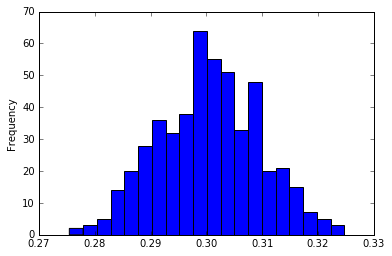

In [18]:
realVols.plot(kind='hist', bins=20)

## Scatter plot between Realized Vol and Break Even Vol

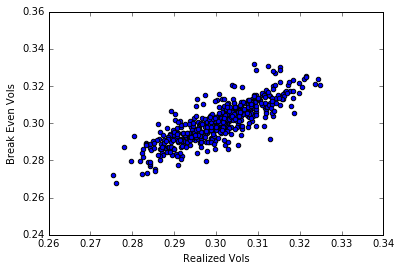

In [21]:
plt.scatter(realVols, bevs)
plt.xlabel("Realized Vols")
plt.ylabel("Break Even Vols")